#### autoreload modules and utilities

In [52]:
%reload_ext autoreload
%autoreload 2

#### import all neceesary libraries/packages

In [53]:
import joblib

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

#### Import necessary utilities

The utilities file is for cleaning of the text

In [54]:
## utilities
from utils import clean_text, DenseTransformer

### Load all the data

We will be using combination of of imdb, yelp and amazon cells users' review

In [55]:
df_imdb = pd.read_csv('data/imdb_labelled.txt', sep='\t', names=[ 'review', 'label'])

df_yelp = pd.read_csv('data/yelp_labelled.txt', sep='\t', names=[ 'review', 'label'])

df_amzn = pd.read_csv('data/amazon_cells_labelled.txt', sep='\t', names=[ 'review', 'label'])

Checking the shape for each dataset

In [56]:
df_imdb.shape, df_yelp.shape, df_amzn.shape

((748, 2), (1000, 2), (1000, 2))

###### We join the dataset together

In [57]:
data = df_imdb.append([df_yelp, df_amzn], ignore_index=True)

In [58]:
# Checeking the data shape
data.shape

(2748, 2)

### Create Label (Positive/Negative)

In [59]:
data['sentiment'] = data["label"].apply(lambda x: "positive" if x else "negative")
data.head()

,review,label,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0,negative
1,Not sure who was more lost - the flat characte...,0,negative
2,Attempting artiness with black & white and cle...,0,negative
3,Very little music or anything to speak of.,0,negative
4,The best scene in the movie was when Gerardo i...,1,positive


### Missing values

In [60]:
data.isnull().sum()

review       0
label        0
sentiment    0
dtype: int64

###### We check for the sum of missing values if there exist any, fortunately there is no missing value in the dataset 

### Label Frequency

positive    1386
negative    1362
Name: sentiment, dtype: int64



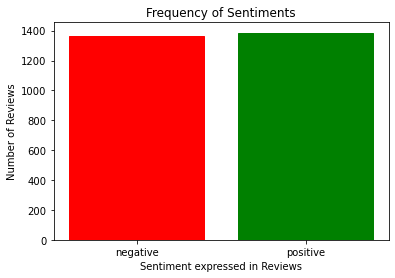

In [61]:
Index = [1, 0]

print(data["sentiment"].value_counts())
print()

barlist = plt.bar(Index, data["sentiment"].value_counts())

plt.title("Frequency of Sentiments")
plt.xticks(Index, ['positive', 'negative'])
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment expressed in Reviews')

barlist[Index[1]].set_color('green')
barlist[Index[0]].set_color('red')
plt.show()

The Dataset labels seems to be balanced, there will be no need for any under/over sampling

### Cleaning of Data
This is done by using utilities function(clean_text) as .apply parameter

In [62]:
data['clean_review'] = data["review"].apply(clean_text)
data.head()

,review,label,sentiment,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,negative,a very very very slowmoving aimless movie abou...
1,Not sure who was more lost - the flat characte...,0,negative,not sure who wa more lost the flat character o...
2,Attempting artiness with black & white and cle...,0,negative,attempting artiness with black white and cleve...
3,Very little music or anything to speak of.,0,negative,very little music or anything to speak of
4,The best scene in the movie was when Gerardo i...,1,positive,the best scene in the movie wa when gerardo is...


# Visualisation of Review

We will be visualising the review using wordcloud module. The module visualised the most frequent words in large size and the less frequent words in smaller sizes.

#### Objective:
    1. To know the most frequent words
    2. Words that contributed to Negative stress
    3. Words that contributed to Positive stress

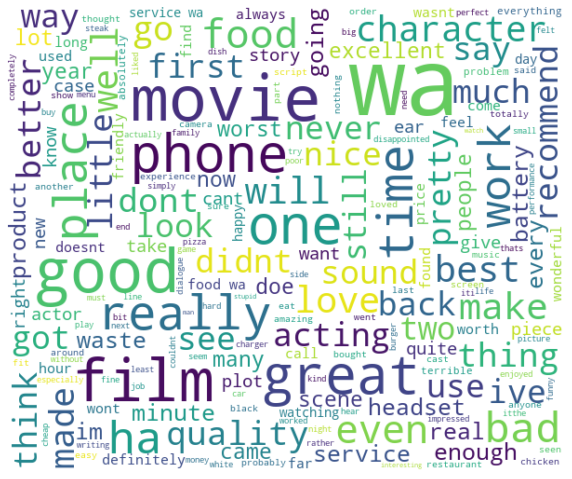

In [63]:
words = ''.join([text for text in data['clean_review']])

cloud_word = WordCloud(width= 600, height = 500, random_state = 31, max_font_size = 100, background_color='white').generate(words)

plt.figure(figsize = (10, 15))
plt.imshow(cloud_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With film, movie, good, character being the most frequent ones.  Similarly, we will plot the word cloud for the Positive and Negative score.

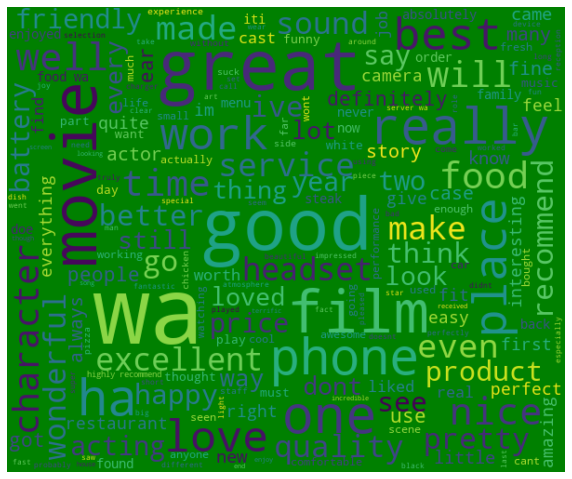

In [64]:
positive_words = ''.join([text for text in data['clean_review'][data['label']==1]])

cloud_word = WordCloud(width= 600, height = 500, max_font_size = 100, background_color='green').generate(positive_words)

plt.figure(figsize = (10, 25))
plt.imshow(cloud_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

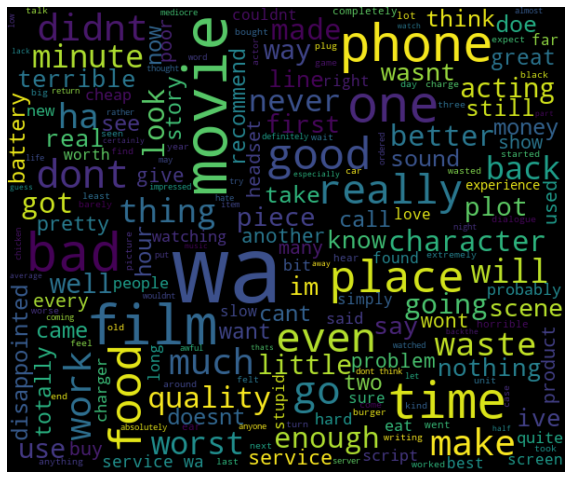

In [65]:
negative_words = ''.join([text for text in data['clean_review'][data['label']==0]])

cloud_word = WordCloud(width= 600, height = 500, max_font_size = 100, background_color='black').generate(negative_words)

plt.figure(figsize = (10, 15))
plt.imshow(cloud_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

Despite the fact that it was saturated by common words like film, watch, very etc; there are nagative words like bore, suck, redicule etc.

## Text preprocessing

Observe count vectorizer

In [66]:
count_vectorizer = CountVectorizer(stop_words='english', binary=True)

count_data = count_vectorizer.fit_transform(data["clean_review"])
cv_dataframe = pd.DataFrame(count_data.toarray(), columns=count_vectorizer.get_feature_names())

cv_dataframe.head()

,010,10,100,1010,11,110,1199,12,13,15,...,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiestudents,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
assert cv_dataframe.max().max()==1, "Maximum value must be One"

### Splitting of Data 

In [68]:
X = data['clean_review']
y = data['label']

###### This is where we split the dataset in preparation for the training using a sklearn module named train_test_split, reviews ia what we are using to make predictions therefore it is our feature in this case and scores of the reviews is our target variable, what we are predicting.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)

print(f"train shape input:{X_train.shape}, output:{y_train.shape}")
print(f"test shape  input:{X_test.shape}, output:{y_test.shape}")

train shape input:(2198,), output:(2198,)
test shape  input:(550,), output:(550,)


###### What CountVectorizer and Vectorizers do is to split the sentences into words, count the number of occurences of each word which is called bag of word model, the higher the frequency of a word really means its not so important or close to irrelevance, therefore the inverse logarithm is been carried out, with the result, you can easily deduce that the closer the value is towards 0 the less relevant it is. They are a very useful preprocessing tool used for text classification model.

### Training with Countvectorizer and CategoricalNB

In [70]:
cv_NB = Pipeline([
    ('bow', CountVectorizer(stop_words="english", binary=True)),
    ("dense", DenseTransformer()),
    ('classifier', CategoricalNB())
])

In [71]:
cv_NB.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(binary=True, stop_words='english')),
                ('dense', DenseTransformer()),
                ('classifier', CategoricalNB())])

#### Creating joblib for deploment

In [72]:
joblib.dump(cv_NB, "models/categorical_naive_bayes_with_count_vectorizer.joblib")

['models/categorical_naive_bayes_with_count_vectorizer.joblib']

In [73]:
y_pred = cv_NB.predict(X_test) #predict testing data

print("\nCountvectorizer and CategoricalNB (Metrics)\n")
print(classification_report(y_test,  y_pred))


Countvectorizer and CategoricalNB (Metrics)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       281
           1       0.70      0.82      0.76       269

    accuracy                           0.74       550
   macro avg       0.75      0.75      0.74       550
weighted avg       0.75      0.74      0.74       550



### Running Cross validation with Countvectorizer and CategoricalNB

In [74]:
accuracy = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10) 
skf.get_n_splits(X, y) 

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    cv_NB.fit(x_train_fold, y_train_fold)
    result = cv_NB.score(x_test_fold, y_test_fold)
    accuracy.append(result)

accuracy = np.array(accuracy)

# Print the output
print('List of first 10 possible accuracy:')
for index, acc in enumerate(accuracy[:10]):
    print(f"{index+1:3d}. {acc:.4f}")

print('\nMetrics that were obtained from this model:')
print(f' Maximum Accuracy:   {accuracy.max()*100:.2f}%') 
print(f' Minimum Accuracy:   {accuracy.min()*100:.2f}%') 
print(f' Mean Accuracy:      {accuracy.mean()*100:.2f}%') 
print(f' Standard Deviation: {accuracy.std():.4f}')

List of first 10 possible accuracy:
  1. 0.7891
  2. 0.7782
  3. 0.7964
  4. 0.7745
  5. 0.8109
  6. 0.8145
  7. 0.8182
  8. 0.7745
  9. 0.7920
 10. 0.8394

Metrics that were obtained from this model:
 Maximum Accuracy:   83.94%
 Minimum Accuracy:   77.45%
 Mean Accuracy:      79.88%
 Standard Deviation: 0.0204
